# Clasificador de Imágenes: Piezas de ajedrez

In [ ]:
import os
from pathlib import Path
import shutil

import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets

Creamos un clasificador básico usando los datos originales.

In [2]:
# Definimos las transformaciones para normalizar los datos
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Ruta de las imágenes
data_path = 'data/raw/Chess'

# Cargamos todas las imágenes de la carpeta con ImageFolder
full_data = datasets.ImageFolder(root=data_path, transform=transform)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))  # 80% para entrenamiento
test_size = len(full_data) - train_size  # 20% para prueba

train_data, test_data = random_split(full_data, [train_size, test_size])

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [50]:
class ConvNet(nn.Module):
    def __init__(self, classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, len(classes))
        self.classes = classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class ConvNet2(nn.Module):
    def __init__(self, classes):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, len(classes))
        self.classes = classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        #print(x.shape)
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class ConvNet3(nn.Module):
    def __init__(self, classes):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(1024 * 1*1, 2048)
        self.fc2 = nn.Linear(2048, len(classes))
        self.classes = classes

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        #print(x.shape)
        x = x.view(-1, 1024 * 1*1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [27]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):
        """
        Inicializa el criterio para la parada temprana.
        
        Args:
            tolerance (int): Número de épocas sin mejora para detener el entrenamiento.
            min_delta (float): La mínima mejora que se necesita en la pérdida de validación.
        """
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.best_val_loss = float('inf')

    def __call__(self, validation_loss):
        """
        Llama a la función con la pérdida de entrenamiento y de validación.
        
        Args:
            train_loss (float): La pérdida en el conjunto de entrenamiento.
            validation_loss (float): La pérdida en el conjunto de validación.
        """
        if (self.best_val_loss - validation_loss) > self.min_delta:
            self.counter = 0  
            self.best_val_loss = validation_loss
        else:
            self.counter += 1 
        
        if self.counter >= self.tolerance:
            self.early_stop = True
            print("Parada temprana activada. No hay mejora en la pérdida de validación.")

In [30]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_train_loss, accuracy

def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_test_loss, accuracy, all_labels, all_preds

def plot_metrics(epochs_trained, train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds, classes):
    """
    Genera gráficas de las métricas: pérdida y precisión, además de la matriz de confusión.
    """
    # Gráfico de pérdidas
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs_trained + 1), train_losses[:epochs_trained], label="Training Loss")
    plt.plot(range(1, epochs_trained + 1), test_losses[:epochs_trained], label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss")
    plt.legend()

    # Gráfico de precisión
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs_trained + 1), train_accuracies[:epochs_trained], label="Training Accuracy")
    plt.plot(range(1, epochs_trained + 1), test_accuracies[:epochs_trained], label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Test Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Crear y graficar la matriz de confusión
    confusion_matrix = np.zeros((len(classes), len(classes)), dtype=int)
    for true_label, pred_label in zip(all_labels, all_preds):
        confusion_matrix[true_label, pred_label] += 1

    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(confusion_matrix, cmap='Blues')
    plt.colorbar(cax)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticklabels(classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="black")

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

def train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    epochs_trained = 0

    for epoch in range(epochs):
        # Entrenamiento por una época
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch + 1}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy}%")

        # Evaluación en el conjunto de prueba
        test_loss, test_accuracy, all_labels, all_preds = evaluate(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch + 1}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%")

        # Early stopping
        if early_stopping:
            early_stopping(test_loss)
            if early_stopping.early_stop:
                print(f"Entrenamiento detenido en la época {epoch + 1} debido a la parada temprana.")
                epochs_trained = epoch + 1
                break
    else:
        epochs_trained = epochs

    # Graficar resultados
    plot_metrics(epochs_trained, train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds, model.classes)
    return model

Clasificador básico:

(Sin parada temprana)

Epoch 1, Training Loss: 1.8435684783118111, Training Accuracy: 16.780045351473923%
Epoch 1, Test Loss: 1.779814600944519, Test Accuracy: 11.711711711711711%
Epoch 2, Training Loss: 1.7695272990635462, Training Accuracy: 23.12925170068027%
Epoch 2, Test Loss: 1.7789562940597534, Test Accuracy: 24.324324324324323%
Epoch 3, Training Loss: 1.7092914155551366, Training Accuracy: 29.25170068027211%
Epoch 3, Test Loss: 1.7733475863933563, Test Accuracy: 23.423423423423422%
Epoch 4, Training Loss: 1.6071438704218184, Training Accuracy: 33.78684807256236%
Epoch 4, Test Loss: 1.7427186071872711, Test Accuracy: 28.82882882882883%
Epoch 5, Training Loss: 1.4318961160523551, Training Accuracy: 46.93877551020408%
Epoch 5, Test Loss: 1.7902321815490723, Test Accuracy: 30.63063063063063%
Epoch 6, Training Loss: 1.2580190428665705, Training Accuracy: 50.34013605442177%
Epoch 6, Test Loss: 1.9045853018760681, Test Accuracy: 21.62162162162162%
Epoch 7, Training Loss: 1.0991021990776062, Training Accuracy

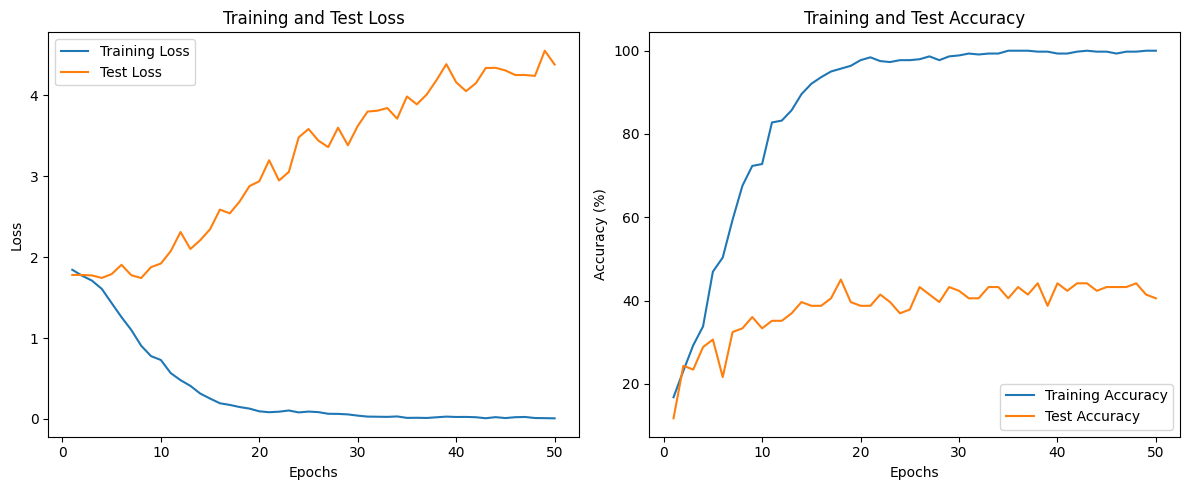

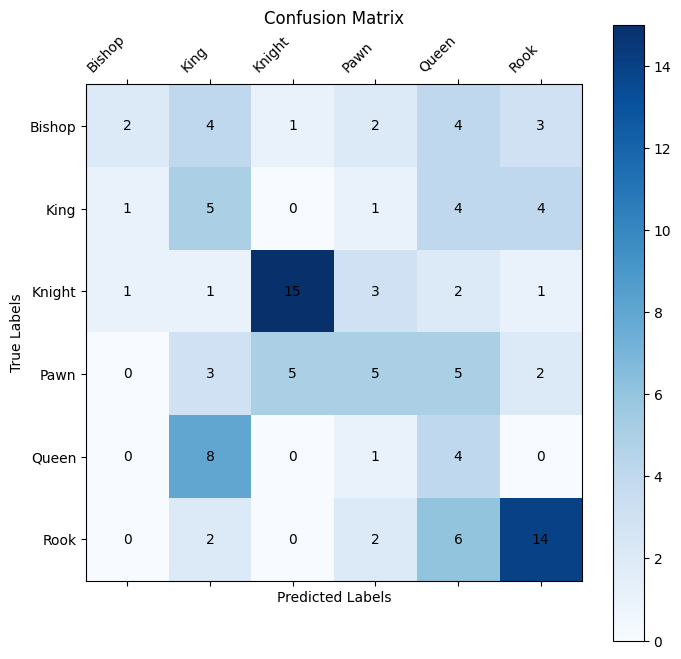

In [32]:
# Configuración inicial
model = ConvNet(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

# Entrenamiento
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, [], epochs=50)

(Con parada temprana)

Epoch 1, Training Loss: 1.8075058375086104, Training Accuracy: 16.3265306122449%
Epoch 1, Test Loss: 1.7936750054359436, Test Accuracy: 12.612612612612613%
Epoch 2, Training Loss: 1.7547952021871294, Training Accuracy: 26.984126984126984%
Epoch 2, Test Loss: 1.7558969855308533, Test Accuracy: 25.225225225225227%
Epoch 3, Training Loss: 1.6175873364721025, Training Accuracy: 36.281179138321995%
Epoch 3, Test Loss: 1.7983844876289368, Test Accuracy: 23.423423423423422%
Epoch 4, Training Loss: 1.4210510424205236, Training Accuracy: 46.03174603174603%
Epoch 4, Test Loss: 1.704118013381958, Test Accuracy: 34.234234234234236%
Epoch 5, Training Loss: 1.2113216859953744, Training Accuracy: 52.15419501133787%
Epoch 5, Test Loss: 1.7305074334144592, Test Accuracy: 29.72972972972973%
Epoch 6, Training Loss: 1.0087911529200417, Training Accuracy: 62.358276643990926%
Epoch 6, Test Loss: 1.7181430459022522, Test Accuracy: 35.13513513513514%
Epoch 7, Training Loss: 0.8599389025143215, Training Accura

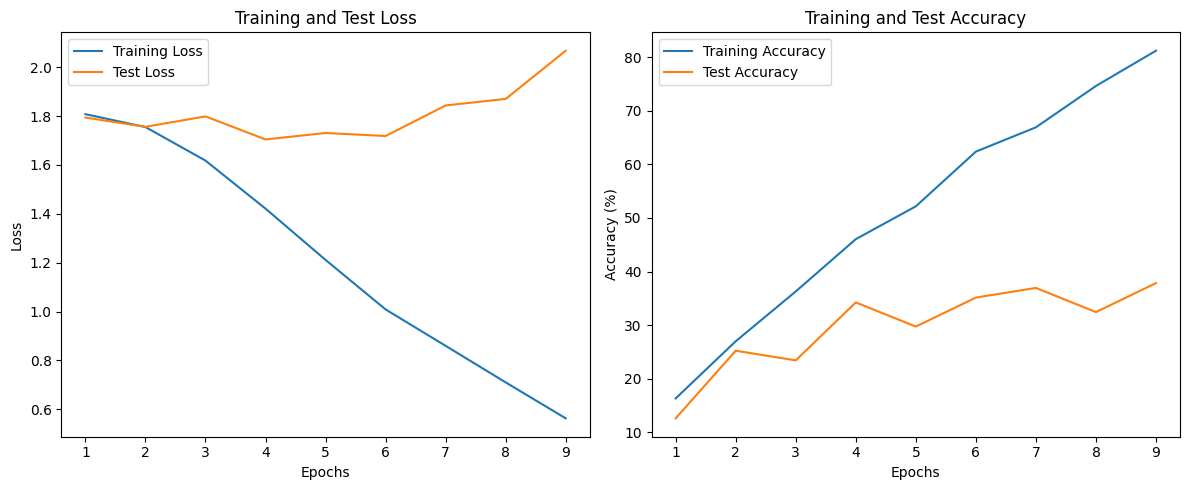

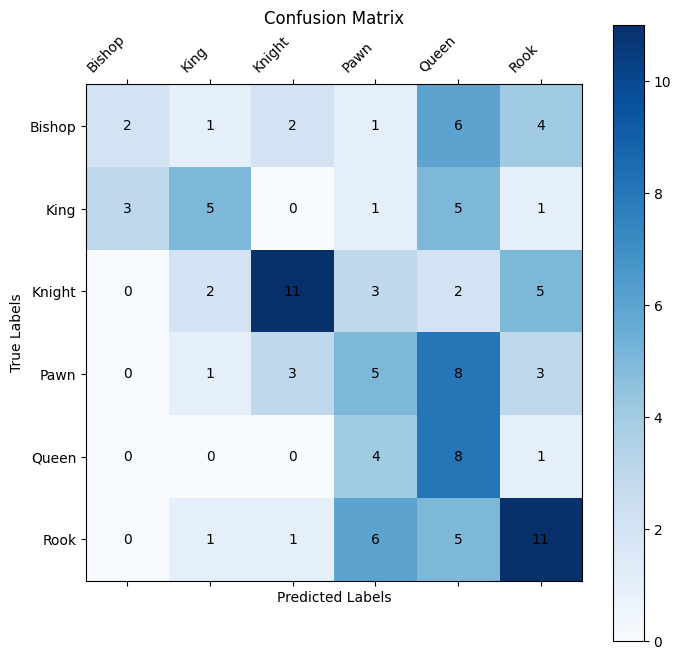

In [ ]:
model = ConvNet(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)


Usando 4 capas convolutivas

Epoch 1, Training Loss: 1.7914625746863229, Training Accuracy: 17.913832199546484%
Epoch 1, Test Loss: 1.7812429070472717, Test Accuracy: 18.01801801801802%
Epoch 2, Training Loss: 1.7886298894882202, Training Accuracy: 19.501133786848072%
Epoch 2, Test Loss: 1.7855421602725983, Test Accuracy: 18.01801801801802%
Epoch 3, Training Loss: 1.7833008766174316, Training Accuracy: 19.501133786848072%
Epoch 3, Test Loss: 1.7756972312927246, Test Accuracy: 18.01801801801802%
Epoch 4, Training Loss: 1.7807212471961975, Training Accuracy: 19.501133786848072%
Epoch 4, Test Loss: 1.7744066417217255, Test Accuracy: 18.01801801801802%
Epoch 5, Training Loss: 1.7680584277425493, Training Accuracy: 23.356009070294785%
Epoch 5, Test Loss: 1.7997190952301025, Test Accuracy: 22.52252252252252%
Epoch 6, Training Loss: 1.749967873096466, Training Accuracy: 19.954648526077097%
Epoch 6, Test Loss: 1.7643188536167145, Test Accuracy: 25.225225225225227%
Epoch 7, Training Loss: 1.699710258415767, Training Accura

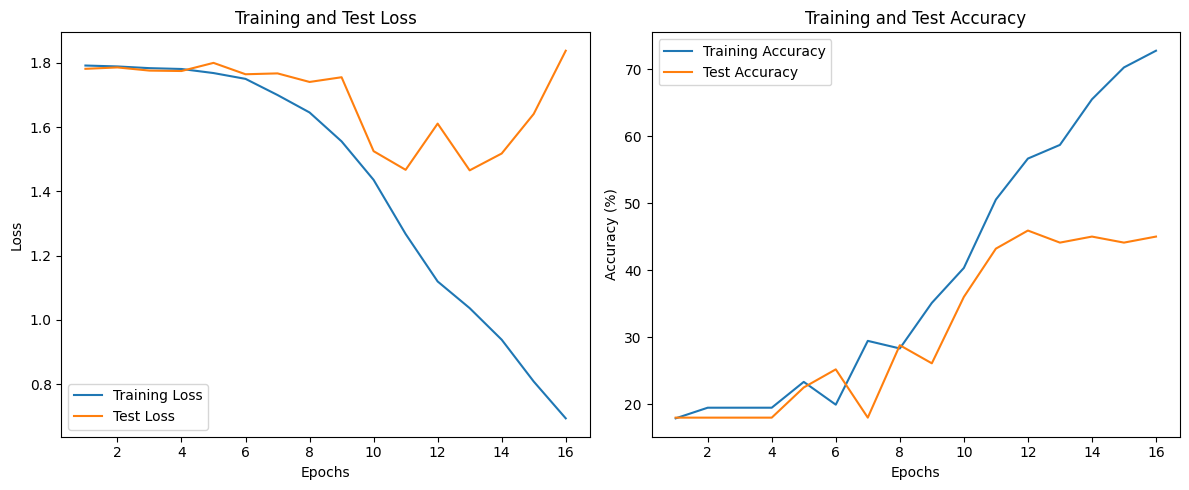

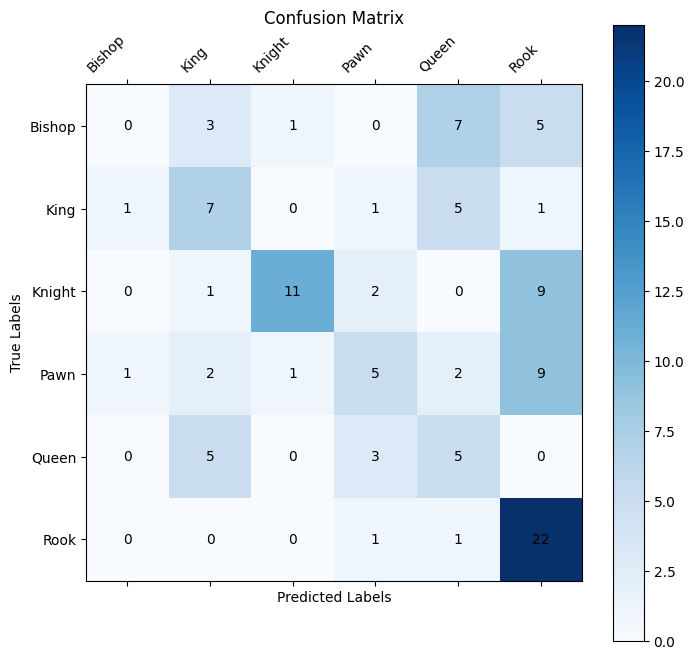

In [ ]:
model = ConvNet2(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)

6 capas convolutivas y dropout

Epoch 1, Training Loss: 1.846224742276328, Training Accuracy: 19.27437641723356%
Epoch 1, Test Loss: 1.79056516289711, Test Accuracy: 18.01801801801802%
Epoch 2, Training Loss: 1.7883233768599374, Training Accuracy: 19.501133786848072%
Epoch 2, Test Loss: 1.7800325751304626, Test Accuracy: 20.72072072072072%
Epoch 3, Training Loss: 1.784821433680398, Training Accuracy: 18.140589569160998%
Epoch 3, Test Loss: 1.7774658799171448, Test Accuracy: 20.72072072072072%
Epoch 4, Training Loss: 1.7826476437704903, Training Accuracy: 19.954648526077097%
Epoch 4, Test Loss: 1.7794101536273956, Test Accuracy: 18.01801801801802%
Epoch 5, Training Loss: 1.7772511158670699, Training Accuracy: 20.408163265306122%
Epoch 5, Test Loss: 1.782371610403061, Test Accuracy: 18.91891891891892%
Epoch 6, Training Loss: 1.7744407398360116, Training Accuracy: 20.18140589569161%
Epoch 6, Test Loss: 1.7596185803413391, Test Accuracy: 19.81981981981982%
Epoch 7, Training Loss: 1.7675212025642395, Training Accuracy: 20

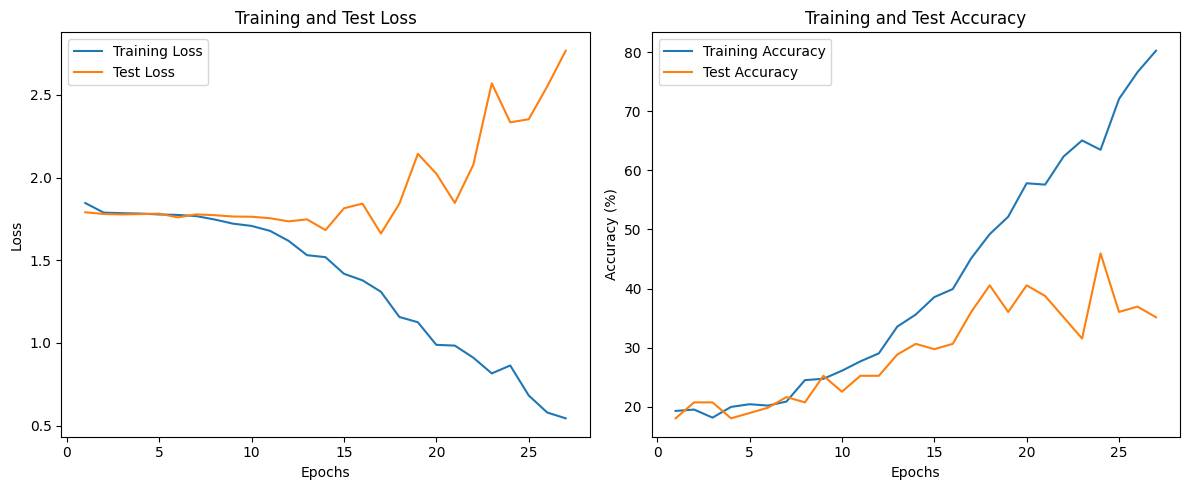

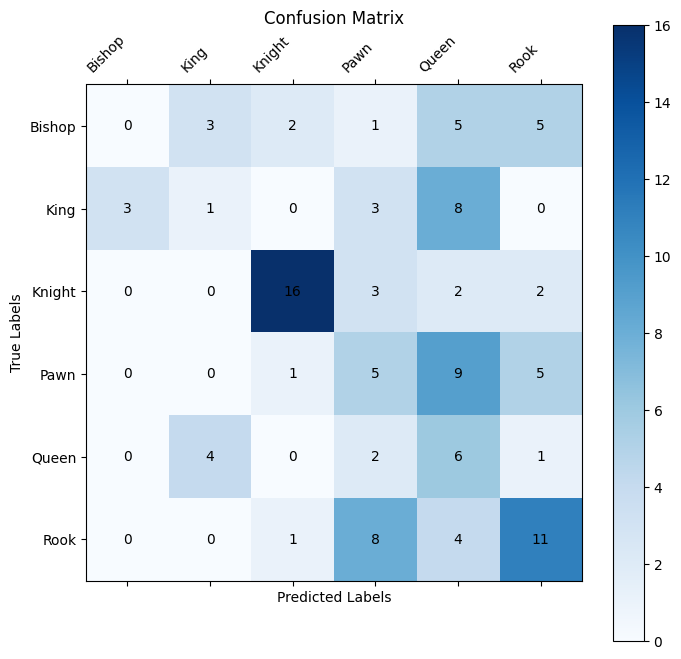

In [52]:
model = ConvNet3(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=10, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)